In [1]:
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Подготовка данных

### Функция для чтения датасета

In [5]:
def read_data(fpath):
    data = []
    with open(fpath, 'r') as f:
        for line in f:
            ex = {}
            for subline in line[1:-2].replace('"', '').split(', '):
                key, value = subline.split(': ')
                try:
                    ex[key] = int(value)
                except Exception:
                    ex[key] = value
            data.append(ex)
    return data

В коллекции уже представлен обработанный датасет. Произведена лемматизация, удалены стоп-слова и знаки препинания. Поэтому попробуем использовать уже подготовленные данные.

In [6]:
train_data = read_data('imdb/lemmatized_wo_stopwords/train')

#### Сразу посмотрим на то, как связаны label и score

In [7]:
ones_twos = np.zeros((10, 2))
for s in train_data:
    i = s['score'] - 1
    j = s['label'] - 1
    ones_twos[i, j] += 1
ones_twos

array([[   0., 5100.],
       [   0., 2284.],
       [   0., 2420.],
       [   0., 2696.],
       [   0.,    0.],
       [   0.,    0.],
       [2496.,    0.],
       [3009.,    0.],
       [2263.,    0.],
       [4732.,    0.]])

Видим, что score 5 и 6 отсутствует, высоким оценкам (7-10) соответствует label 1, а низким (1-4) - 2.
Поэтому задача определения score автоматически решает задачу определения label.

### Посмотрим на данные --- количество, среднюю и минимальную длину текстов.

In [8]:
count_data = len(train_data)
data_length = sorted([len(sample['text'].split()) for sample in train_data])
print('Count of samples: {}\nMean length: {}\nStd: {}\nMinimum: {}\n10%: {}\n25%: {}\n50%: {}\n'
      '75%: {}\n90%: {}\nMaximum: {}'.format(count_data, np.mean(data_length), np.std(data_length), 
                                             data_length[0], data_length[count_data//10], 
                                             data_length[count_data//4], data_length[count_data//2], 
                                             data_length[count_data * 3//4], data_length[count_data * 9//10], 
                                             data_length[-1]))

Count of samples: 25000
Mean length: 117.6394
Std: 88.88958098472509
Minimum: 3
10%: 45
25%: 62
50%: 87
75%: 143
90%: 233
Maximum: 1416


Видно, что разброс в данных большой. Вспоминая специфику данных -- отзывы к фильмам -- понимаем, что большинство пользователей пишут коротко, и лишь некоторые растекаются мысью по древу.
Во всяком случае, это не твиттер с 30-40 словами, поэтому можно ожидать приемлемых результатов.

### Функция для перевода данных в формат BigARTM

In [7]:
def prepare_train_data_for_bigartm(data, bigartm_data_path):
    with open(bigartm_data_path, 'w') as f:
        for i, sample in enumerate(data):
            f.write('review_{} {} |@score {}\n'.format(i, sample['text'], sample['score']))

In [8]:
def prepare_test_data_for_bigartm(data, bigartm_data_path):
    with open(bigartm_data_path, 'w') as f:
        for i, sample in enumerate(data):
            f.write('review_{} {}\n'.format(i, sample['text']))

In [9]:
train_set, val_set = train_test_split(train_data, test_size=0.2)
prepare_train_data_for_bigartm(train_set, 'train.txt')
prepare_test_data_for_bigartm(val_set, 'val.txt')
train_scores = [x['score'] for x in train_set]
val_scores = [x['score'] for x in val_set]

## Построим модель BigARTM

### Сначала определим vectorizer и сохраним словарь

In [10]:
import artm
import pyLDAvis

artm.ARTM(num_topics=1)
print(artm.version())

warnings.filterwarnings('ignore')

0.9.2


In [11]:
bv_train = artm.BatchVectorizer(data_path='train.txt', data_format='vowpal_wabbit', 
                                batch_size=10000, target_folder='train_batches')

In [12]:
bv_val = artm.BatchVectorizer(data_path='val.txt', data_format='vowpal_wabbit', 
                              batch_size=10000, target_folder='val_batches')

In [13]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='train_batches')

### Инициализируем модель и добавим метрики качества

In [14]:
model = artm.ARTM(num_topics=100, dictionary=dictionary, class_ids={'@default_class': 1.0, '@score': 5.0})

model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=15))
model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@score'))
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))

### В качестве первой попытки обучим модель без регуляризаторов

In [15]:
for i in range(30):
    model.fit_offline(bv_train, num_collection_passes=1)
    print('Iteration {}: sparsity = {}, perplexity = {}'.format(\
        i, model.score_tracker['sparsity'].value[-1], model.score_tracker['perplexity'].value[-1]
    ))

Iteration 0: sparsity = 0.0, perplexity = 469871.375
Iteration 1: sparsity = 0.0, perplexity = 17075.998046875
Iteration 2: sparsity = 0.0, perplexity = 10442.12109375
Iteration 3: sparsity = 0.0, perplexity = 6890.9521484375
Iteration 4: sparsity = 0.0, perplexity = 5574.27783203125
Iteration 5: sparsity = 0.0, perplexity = 5052.9931640625
Iteration 6: sparsity = 0.0, perplexity = 4818.98974609375
Iteration 7: sparsity = 0.0, perplexity = 4706.3388671875
Iteration 8: sparsity = 0.0, perplexity = 4654.90380859375
Iteration 9: sparsity = 0.0, perplexity = 4637.9873046875
Iteration 10: sparsity = 0.0024999999441206455, perplexity = 4641.61962890625
Iteration 11: sparsity = 0.007499999832361937, perplexity = 4658.40673828125
Iteration 12: sparsity = 0.01875000074505806, perplexity = 4682.6748046875
Iteration 13: sparsity = 0.026249999180436134, perplexity = 4710.31591796875
Iteration 14: sparsity = 0.04500000178813934, perplexity = 4739.27783203125
Iteration 15: sparsity = 0.0524999983608

In [16]:
X_train_pd = model.transform(bv_train)
X_train = np.array([X_train_pd[i].values for i in range(len(train_scores))])
y_train = np.array(train_scores)
X_val_pd = model.transform(bv_val)
X_val = np.array([X_val_pd[i].values for i in range(len(val_scores))])
y_val = np.array(val_scores)
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)
results = {}
results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
results['val'] = classification_report(y_val, y_val_pred, zero_division=1)
print(results['train'])
print(results['val'])

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      4065
           2       1.00      1.00      1.00      1878
           3       1.00      0.99      1.00      1927
           4       1.00      1.00      1.00      2135
           7       1.00      1.00      1.00      1990
           8       1.00      1.00      1.00      2418
           9       1.00      1.00      1.00      1832
          10       1.00      1.00      1.00      3755

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.41      0.63      0.49      1035
           2       0.11      0.11      0.11       406
           3       0.11      0.11      0.11       493
           4       0.20      0.21      0.20       561
           7       0.24      0.17      0.19       506
           8       0.22 

Видим, что с 10 итерации перплексия начинает расти -- эффект переобучения. И, ожидаемо, качество на валидации оказалось очень плохим. Значит, надо использовать регуляризаторы или сократить число итераций. Чтобы не копировать постоянно код, напишем функцию, создающую и обучающую модель. Но сначала -- 10 итераций.

In [19]:
model = artm.ARTM(num_topics=100, dictionary=dictionary, class_ids={'@default_class': 1.0, '@score': 5.0})

model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=15))
model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@score'))
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))

for i in range(10):
    model.fit_offline(bv_train, num_collection_passes=1)
    print('Iteration {}: sparsity = {}, perplexity = {}'.format(\
        i, model.score_tracker['sparsity'].value[-1], model.score_tracker['perplexity'].value[-1]
    ))

Iteration 0: sparsity = 0.0, perplexity = 471030.71875
Iteration 1: sparsity = 0.0, perplexity = 17012.111328125
Iteration 2: sparsity = 0.0, perplexity = 10382.5693359375
Iteration 3: sparsity = 0.0, perplexity = 6861.544921875
Iteration 4: sparsity = 0.0, perplexity = 5559.42578125
Iteration 5: sparsity = 0.0, perplexity = 5047.93896484375
Iteration 6: sparsity = 0.0, perplexity = 4821.7041015625
Iteration 7: sparsity = 0.0, perplexity = 4712.08203125
Iteration 8: sparsity = 0.0, perplexity = 4658.92138671875
Iteration 9: sparsity = 0.0, perplexity = 4638.44775390625


In [20]:
X_train_pd = model.transform(bv_train)
X_train = np.array([X_train_pd[i].values for i in range(len(train_scores))])
y_train = np.array(train_scores)
X_val_pd = model.transform(bv_val)
X_val = np.array([X_val_pd[i].values for i in range(len(val_scores))])
y_val = np.array(val_scores)
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)
results = {}
results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
results['val'] = classification_report(y_val, y_val_pred, zero_division=1)
print(results['train'])
print(results['val'])

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.40      0.66      0.50      1002
           2       0.15      0.12      0.13       475
           3       0.15      0.16      0.15       489
           4       0.19      0.16      0.17       559
           7       0.21      0.16      0.18       499
           8       0.24 

А если больше эстиматоров в решающем лесу?

In [21]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)
results = {}
results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
results['val'] = classification_report(y_val, y_val_pred, zero_division=1)
print(results['train'])
print(results['val'])

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.44      0.71      0.54      1002
           2       0.16      0.09      0.12       475
           3       0.16      0.13      0.15       489
           4       0.23      0.20      0.21       559
           7       0.21      0.16      0.18       499
           8       0.26 

Уже лучше. А если не 20, а 50?

In [22]:
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)
results = {}
results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
results['val'] = classification_report(y_val, y_val_pred, zero_division=1)
print(results['train'])
print(results['val'])

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.45      0.75      0.56      1002
           2       0.14      0.07      0.10       475
           3       0.18      0.12      0.15       489
           4       0.23      0.20      0.22       559
           7       0.20      0.14      0.17       499
           8       0.27 

Accuracy 0.34. Пора пробовать регуляризаторы. Испытаем три: декоррелятор на входных данных, декоррелятор на классах, сглаживатель-разреживатель.

# Функция для создания и обучения модели с регуляризаторами

In [17]:
def create_and_fit_model_with_regularizers(bv_train, num_topics, epochs, 
                                           tau_def, tau_score, tau_smooth, score_idx, verbose=1):
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, 
                      class_ids={'@default_class': 1.0, '@score': score_idx})
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=15))
    model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@score'))
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    
    if tau_def > 0:
        model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_default', 
                                                               tau=tau_def,
                                                               class_ids=['@default_class']))
    if tau_score > 0:
        model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_score', 
                                                               tau=tau_score,
                                                               class_ids=['@score']))
    if tau_smooth > 0:
        model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smoothing', 
                                                               tau=tau_smooth,
                                                               class_ids=['@score']))
    old_sparsity = -1
    old_perplexity = -1
    stop = 5
    iter_done = epochs
    for i in range(epochs):
        model.fit_offline(bv_train, num_collection_passes=1)
        sparsity = model.score_tracker['sparsity'].value[-1]
        perplexity = model.score_tracker['perplexity'].value[-1]
        if verbose == 2:
            print('Iteration {}: sparsity = {}, perplexity = {}'.format(i, sparsity, perplexity))
        if sparsity < old_sparsity or old_perplexity != -1 and perplexity > old_perplexity:
            stop -= 1
            if stop == 0:
                iter_done = i + 1
                break
        else:
            old_sparsity = sparsity
            old_perplexity = perplexity
    if verbose == 1:
        print('Iteration {}: sparsity = {}, perplexity = {}'.format(iter_done, sparsity, perplexity))
    return model

## Функция, которая для заданных параметров обучает модель и оценивает её на валидационных данных

In [18]:
def evaluate_hyperparameters(bv_train, bv_val, scores_train, scores_val, classifier, 
                             num_topics, epochs, tau_def, tau_score, tau_smooth, score_idx, verbose=1):
    model = create_and_fit_model_with_regularizers(bv_train, num_topics, epochs, 
                                                   tau_def, tau_score, tau_smooth, score_idx, verbose)
    X_train_pd = model.transform(bv_train)
    X_train = np.array([X_train_pd[i].values for i in range(len(scores_train))])
    y_train = np.array(scores_train)
    X_val_pd = model.transform(bv_val)
    X_val = np.array([X_val_pd[i].values for i in range(len(scores_val))])
    y_val = np.array(scores_val)
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_val_pred = classifier.predict(X_val)
    results = {}
    results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
    results['val'] = classification_report(y_val, y_val_pred, zero_division=1)
    return results['train'], results['val'], model

Проверяем первый регуляризатор с $\tau=10000$

In [25]:
classifier = RandomForestClassifier(n_estimators=10)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    100, 30, 10000, 0, 0, 5)

Iteration 15: sparsity = 0.036249998956918716, perplexity = 4862.2568359375


In [26]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.39      0.63      0.48      1002
           2       0.15      0.14      0.15       475
           3       0.13      0.13      0.13       489
           4       0.17      0.16      0.16       559
           7       0.18      0.12      0.15       499
           8       0.20 

Не улучшает. Попробуем $\tau=100000$

In [27]:
classifier = RandomForestClassifier(n_estimators=10)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    100, 30, 100000, 0, 0, 5)

Iteration 15: sparsity = 0.026249999180436134, perplexity = 4502.76025390625


In [28]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      0.99      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.37      0.67      0.48      1002
           2       0.16      0.11      0.13       475
           3       0.13      0.12      0.12       489
           4       0.19      0.16      0.18       559
           7       0.15      0.09      0.11       499
           8       0.24 

По крайней мере, перплексия уменьшается. Попробуем взять $\tau=1000000$

In [29]:
classifier = RandomForestClassifier(n_estimators=10)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    100, 30, 1000000, 0, 0, 5)

Iteration 24: sparsity = 0.22750000655651093, perplexity = 4600.70947265625


In [30]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.35      0.73      0.48      1002
           2       0.07      0.02      0.03       475
           3       0.13      0.06      0.08       489
           4       0.15      0.07      0.10       559
           7       0.16      0.14      0.15       499
           8       0.19 

Хватит этой боли. Первый регуляризатор ничего не улучшает, потому летит в топку.

In [31]:
classifier = RandomForestClassifier(n_estimators=10)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    100, 30, 0, 10, 0, 5)

Iteration 15: sparsity = 0.2737500071525574, perplexity = 4669.71826171875


In [32]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.39      0.65      0.49      1002
           2       0.15      0.13      0.14       475
           3       0.14      0.14      0.14       489
           4       0.18      0.16      0.17       559
           7       0.17      0.14      0.15       499
           8       0.22 

In [33]:
classifier = RandomForestClassifier(n_estimators=10)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    100, 30, 0, 100, 0, 5)

Iteration 21: sparsity = 0.9750000238418579, perplexity = 6804.9208984375


In [34]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      0.99      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.38      0.76      0.50      1002
           2       0.16      0.04      0.06       475
           3       0.20      0.11      0.14       489
           4       0.22      0.20      0.21       559
           7       0.25      0.18      0.21       499
           8       0.24 

Перплексия выросла, но качество классификации улучшилось, причём заметно. Попробуем закрепить, взяв больше деревьев.

In [35]:
classifier = RandomForestClassifier(n_estimators=30)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    100, 30, 0, 100, 0, 5)

Iteration 21: sparsity = 0.9750000238418579, perplexity = 6804.9208984375


In [36]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.40      0.77      0.52      1002
           2       0.20      0.04      0.06       475
           3       0.20      0.10      0.13       489
           4       0.24      0.22      0.23       559
           7       0.26      0.15      0.19       499
           8       0.27 

0.35. Хоть что-то. Попробуем присоединить первый регуляризатор ко второму.

In [37]:
classifier = RandomForestClassifier(n_estimators=30)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    100, 30, 10000, 100, 0, 5)

Iteration 17: sparsity = 0.9725000262260437, perplexity = 6724.1650390625


In [38]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.40      0.78      0.53      1002
           2       0.23      0.04      0.07       475
           3       0.20      0.11      0.14       489
           4       0.23      0.22      0.23       559
           7       0.23      0.16      0.19       499
           8       0.28 

Accuracy такое же, а f1 мера чуть выросла. Пытаемся дальше.

In [39]:
classifier = RandomForestClassifier(n_estimators=30)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    100, 30, 100000, 100, 0, 5)

Iteration 12: sparsity = 0.9700000286102295, perplexity = 6616.259765625


In [40]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.43      0.69      0.53      1002
           2       0.12      0.07      0.08       475
           3       0.17      0.14      0.16       489
           4       0.26      0.18      0.21       559
           7       0.22      0.18      0.20       499
           8       0.20 

## Кажется, не очень полезная затея. Пробуем взять 200 тем.

In [41]:
classifier = RandomForestClassifier(n_estimators=30)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    200, 30, 10000, 100, 0, 5)

Iteration 30: sparsity = 1.0, perplexity = 8588.4248046875


In [42]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.41      0.78      0.54      1002
           2       0.15      0.05      0.08       475
           3       0.16      0.11      0.13       489
           4       0.19      0.17      0.18       559
           7       0.21      0.11      0.14       499
           8       0.23 

In [43]:
classifier = RandomForestClassifier(n_estimators=30)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    200, 20, 100000, 10, 0, 5)

Iteration 12: sparsity = 0.9212499856948853, perplexity = 3739.251708984375


In [44]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.40      0.68      0.50      1002
           2       0.13      0.07      0.09       475
           3       0.18      0.09      0.12       489
           4       0.19      0.16      0.17       559
           7       0.17      0.18      0.18       499
           8       0.22 

Рекордно низкая перплексия, а классификация - совсем не на уровне. Больше деревьев!

In [45]:
classifier = RandomForestClassifier(n_estimators=50)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    200, 20, 100000, 10, 0, 5)

Iteration 12: sparsity = 0.9212499856948853, perplexity = 3739.251708984375


In [46]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.41      0.72      0.52      1002
           2       0.15      0.07      0.10       475
           3       0.16      0.08      0.11       489
           4       0.22      0.15      0.18       559
           7       0.18      0.18      0.18       499
           8       0.25 

#### Попробуем третий регуляризатор.

In [47]:
classifier = RandomForestClassifier(n_estimators=50)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    200, 20, 0, 0, 10, 5)

Iteration 15: sparsity = 0.054375000298023224, perplexity = 3864.0283203125


In [48]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.40      0.73      0.51      1002
           2       0.15      0.05      0.08       475
           3       0.12      0.09      0.11       489
           4       0.25      0.22      0.23       559
           7       0.19      0.16      0.18       499
           8       0.23 

Не хуже и не лучше. Первый к нему, и второй заодно - в их лучшей конфигурации.

In [49]:
classifier = RandomForestClassifier(n_estimators=50)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    200, 20, 10000, 100, 10, 5)

Iteration 20: sparsity = 1.0, perplexity = 8821.5732421875


In [50]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.41      0.79      0.54      1002
           2       0.17      0.05      0.08       475
           3       0.18      0.10      0.13       489
           4       0.25      0.21      0.23       559
           7       0.24      0.11      0.15       499
           8       0.25 

In [51]:
classifier = RandomForestClassifier(n_estimators=50)
tr, v, _ = evaluate_hyperparameters(bv_train, bv_val, train_scores, val_scores, classifier, 
                                    100, 30, 10000, 100, 0, 5)

Iteration 17: sparsity = 0.9725000262260437, perplexity = 6724.1650390625


In [52]:
print(tr)
print(v)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4098
           2       1.00      1.00      1.00      1809
           3       1.00      1.00      1.00      1931
           4       1.00      1.00      1.00      2137
           7       1.00      1.00      1.00      1997
           8       1.00      1.00      1.00      2385
           9       1.00      1.00      1.00      1810
          10       1.00      1.00      1.00      3833

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.41      0.80      0.54      1002
           2       0.20      0.03      0.06       475
           3       0.17      0.08      0.11       489
           4       0.22      0.22      0.22       559
           7       0.24      0.14      0.18       499
           8       0.25 

Accuracy 0.35. Рекордное значение; видимо, на этих данных такими средствами большего не достичь. Выделим модель из кода и посмотрим на результаты ещё раз.

## Рекордная модель после долгих мучений

100 тем

Выполнено 20 итераций

Коэффициенты регуляризаторов 10000, 100 и 0

In [19]:
model = artm.ARTM(num_topics=100, dictionary=dictionary, 
                  class_ids={'@default_class': 1.0, '@score': 5})
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=100))
model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@score'))
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))

model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_default', 
                                                       tau=10000, class_ids=['@default_class']))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_score', 
                                                       tau=100, class_ids=['@score']))

for i in range(20):
    model.fit_offline(bv_train, num_collection_passes=1)
    sparsity = model.score_tracker['sparsity'].value[-1]
    perplexity = model.score_tracker['perplexity'].value[-1]
    print('Iteration {}: sparsity = {}, perplexity = {}'.format(i, sparsity, perplexity))
    
X_train_pd = model.transform(bv_train)
X_train = np.array([X_train_pd[i].values for i in range(len(train_scores))])
y_train = np.array(train_scores)
X_val_pd = model.transform(bv_val)
X_val = np.array([X_val_pd[i].values for i in range(len(val_scores))])
y_val = np.array(val_scores)

classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)
results = {}
results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
results['val'] = classification_report(y_val, y_val_pred, zero_division=1)

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469871.375
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12513.50390625
Iteration 2: sparsity = 0.96875, perplexity = 9772.8193359375
Iteration 3: sparsity = 0.96875, perplexity = 8346.1923828125
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7529.2841796875
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7127.4921875
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6908.1142578125
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6784.4072265625
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6709.66552734375
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6664.8095703125
Iteration 10: sparsity = 0.9700000286102295, perplexity = 6641.49169921875
Iteration 11: sparsity = 0.9700000286102295, perplexity = 6634.55859375
Iteration 12: sparsity = 0.9700000286102295, perplexity = 6639.9619140625
Iteration 13: sparsity = 0.9700000286102295, perplexity = 6654.83447265625
Iter

In [20]:
print(results['train'])
print(results['val'])

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4065
           2       1.00      1.00      1.00      1878
           3       1.00      1.00      1.00      1927
           4       1.00      1.00      1.00      2135
           7       1.00      1.00      1.00      1990
           8       1.00      1.00      1.00      2418
           9       1.00      1.00      1.00      1832
          10       1.00      1.00      1.00      3755

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.44      0.74      0.55      1035
           2       0.19      0.10      0.13       406
           3       0.18      0.11      0.14       493
           4       0.28      0.27      0.27       561
           7       0.27      0.18      0.22       506
           8       0.24 

Посмотрим на матрицу предсказаний.

In [21]:
val_matrix = np.zeros((10, 10))
for tru, prd in zip(y_val, y_val_pred):
    val_matrix[tru-1,prd-1] += 1
print(val_matrix)

[[768.  65.  58.  61.   0.   0.  11.   6.   5.  61.]
 [236.  40.  44.  35.   0.   0.  12.   8.   2.  29.]
 [233.  41.  53.  95.   0.   0.  21.  11.   1.  38.]
 [190.  32.  59. 152.   0.   0.  38.  26.   9.  55.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 80.  11.  25.  69.   0.   0.  92.  68.  18. 143.]
 [ 71.   9.  14.  66.   0.   0.  87.  94.  47. 203.]
 [ 59.   2.  11.  26.   0.   0.  37.  65.  36. 195.]
 [122.   7.  24.  47.   0.   0.  45. 116.  58. 558.]]


In [22]:
np.array([[val_matrix[:4, :4].sum(), val_matrix[:4, 6:].sum()], [val_matrix[6:, :4].sum(), val_matrix[6:, 6:].sum()]])

array([[2162.,  333.],
       [ 643., 1862.]])

### Из таблицы видно, что всё не так плохо, как казалось: в абсолютном большинстве случаев положительные оценки классифицированы как положительные, а отрицательные как отрицательные. А отличить единицу от двойки -- с этим не каждый преподаватель справится.

## Но всё-таки сравним с обычным методом tf-idf без всякого тематического моделирования.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
corpus = [x['text'] for x in train_set]

In [41]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)

In [42]:
X_val = vectorizer.transform([x['text'] for x in val_set])

In [43]:
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [44]:
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)
results = {}
results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
results['val'] = classification_report(y_val, y_val_pred, zero_division=1)

In [45]:
print(results['train'])
print(results['val'])

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4065
           2       1.00      1.00      1.00      1878
           3       1.00      1.00      1.00      1927
           4       1.00      1.00      1.00      2135
           7       1.00      1.00      1.00      1990
           8       1.00      1.00      1.00      2418
           9       1.00      1.00      1.00      1832
          10       1.00      1.00      1.00      3755

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

              precision    recall  f1-score   support

           1       0.39      0.85      0.53      1035
           2       0.17      0.01      0.03       406
           3       0.24      0.04      0.06       493
           4       0.31      0.09      0.13       561
           7       0.24      0.07      0.10       506
           8       0.28 

In [46]:
val_matrix = np.zeros((10, 10))
for tru, prd in zip(y_val, y_val_pred):
    val_matrix[tru-1,prd-1] += 1
print(val_matrix)

[[879.   6.   9.  12.   0.   0.   5.   7.   1. 116.]
 [317.   6.   3.  15.   0.   0.   5.   6.   0.  54.]
 [346.   8.  18.  18.   0.   0.   7.  13.   2.  81.]
 [286.   7.  22.  48.   0.   0.  21.  29.   7. 141.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [123.   5.  12.  22.   0.   0.  33.  61.   6. 244.]
 [108.   1.   5.  19.   0.   0.  25.  81.   7. 345.]
 [ 71.   2.   3.   6.   0.   0.  19.  36.  10. 284.]
 [132.   0.   4.  15.   0.   0.  21.  55.   6. 744.]]


In [47]:
np.array([[val_matrix[:4, :4].sum(), val_matrix[:4, 6:].sum()], [val_matrix[6:, :4].sum(), val_matrix[6:, 6:].sum()]])

array([[2000.,  495.],
       [ 528., 1977.]])

## Accuracy не отличается, а вот f1-score у предсказаний BigARTM лучше. Переходим к основным экспериментам.

Нужно добавить в коллекцию виртуальные документы, в каждом -- n лучших токенов из одной темы. И посмотреть, улучшится ли качество решения задачи классификации. Естественно, у виртуальных документов нет и не может быть никакой метки классификации. Поэтому будем присваивать им фиктивную метку 0 и добавлять их только при обучении тематической модели, а не при решении задачи классификации с помощью случайного решающего леса.

Для начала посмотрим на темы.

In [23]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names:
    print(top_tokens[topic_name])

['anna', 'evening', 'ann', 'simon', 'matthau', 'oscar', 'room', 'walter', 'neil', 'two', 'felix', 'burns', 'play', 'griffith', 'couple', 'busy', 'divorce', 'three', 'lemmon', 'daughter', 'deanna', 'francis', 'scene', 'old', 'young', 'lewis', 'claire', 'harris', 'cassidy', 'spice', 'george', 'die', 'work', 'durbin', 'khouri', 'boys', 'brady', 'madison', 'year', 'together', 'wife', 'forbidden', 'become', 'friend', 'stuart', 'woman', 'willy', 'vanessa', 'al', 'toni', 'lila', 'willie', 'buddy', 'benjamin', 'alicia', 'redgrave', 'mother', 'apartment', 'man', 'wedding', 'jack', 'count', 'later', 'odd', 'collette', 'dani', 'shooting', 'live', 'home', 'sunshine', 'soon', 'create', 'dw', 'another', 'patrick', 'danes', 'robot', 'screenplay', 'star', 'streep', 'meet', 'kirkland', 'first', 'course', 'bring', 'milland', 'last', 'court', 'meryl', 'stage', 'nielsen', 'jordan', 'christensen', 'marry', 'feature', 'lie', 'mistake', 'touch', 'around', 'rich']
['bad', 'guy', 'boring', 'get', 'really', 'wa

Некоторые из них выглядят интерпретируемыми -- например ['film', 'good', 'story', 'one', 'really', 'also', 'well', 'make', 'though', 'pretty', 'much', 'little', 'get', 'look', 'give'] и ['father', 'mother', 'son', 'brother', 'daughter', 'god', 'church', 'jesus', 'christian', 'andy', 'religious', 'religion', 'younger', 'priest', 'dad'].

In [24]:
def prepare_augmented_train_data_for_bigartm(data, bigartm_data_path, top_tokens, n_words, n_docs):
    with open(bigartm_data_path, 'w') as f:
        for i, sample in enumerate(data):
            f.write('review_{} {} |@score {}\n'.format(i, sample['text'], sample['score']))
        for i in range(n_docs):
            for topic_name in model.topic_names:
                text = 'virtual_{}_{} '.format(topic_name, i)
                for j in range(n_words):
                    text += top_tokens[topic_name][i] + ' '
                text += '|@score 0\n'
                f.write(text)

1 документ.

In [25]:
accs = []
f1s = []
for n in range(1, 50):
    prepare_augmented_train_data_for_bigartm(train_set, 'aug_train_{}.txt'.format(n), top_tokens, n, 1)
    bv_aug_train = artm.BatchVectorizer(data_path='aug_train_{}.txt'.format(n), data_format='vowpal_wabbit', 
                                        batch_size=10000, target_folder='aug_train_{}_batches'.format(n))
    new_model = artm.ARTM(num_topics=100, dictionary=dictionary, 
                      class_ids={'@default_class': 1.0, '@score': 5})
    new_model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=100))
    new_model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@score'))
    new_model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))

    new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_default', 
                                                               tau=10000, class_ids=['@default_class']))
    new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_score', 
                                                               tau=100, class_ids=['@score']))

    for i in range(10):
        new_model.fit_offline(bv_aug_train, num_collection_passes=1)
        sparsity = new_model.score_tracker['sparsity'].value[-1]
        perplexity = new_model.score_tracker['perplexity'].value[-1]
        print('Iteration {}: sparsity = {}, perplexity = {}'.format(i, sparsity, perplexity))

    X_train_pd = new_model.transform(bv_train)
    X_train = np.array([X_train_pd[i].values for i in range(len(train_scores))])
    y_train = np.array(train_scores)
    X_val_pd = new_model.transform(bv_val)
    X_val = np.array([X_val_pd[i].values for i in range(len(val_scores))])
    y_val = np.array(val_scores)

    classifier = RandomForestClassifier(n_estimators=50)
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_val_pred = classifier.predict(X_val)
    results = {}
    results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
    results['val'] = classification_report(y_val, y_val_pred, zero_division=1)
    
    print(results['val'])
    
    spl = results['val'].split()
    iddd = spl.index('accuracy') + 1
    accs.append(float(spl[iddd]))
    f1s.append(float(spl[iddd + 12]))
    print(accs, f1s)

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469860.03125
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12512.8642578125
Iteration 2: sparsity = 0.96875, perplexity = 9772.29296875
Iteration 3: sparsity = 0.96875, perplexity = 8345.4931640625
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7528.57568359375
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7126.7275390625
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6907.3564453125
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6783.6923828125
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6708.8642578125
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6663.83935546875
              precision    recall  f1-score   support

           1       0.43      0.79      0.55      1035
           2       0.16      0.06      0.09       406
           3       0.16      0.06      0.09       493
           4       0.28      0.23      0.25       561
           7       0.27

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469791.96875
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12508.880859375
Iteration 2: sparsity = 0.96875, perplexity = 9768.7861328125
Iteration 3: sparsity = 0.96875, perplexity = 8341.11328125
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7524.048828125
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7121.69873046875
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6902.400390625
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6778.96142578125
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6703.85205078125
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6658.7041015625
              precision    recall  f1-score   support

           1       0.43      0.77      0.55      1035
           2       0.16      0.06      0.09       406
           3       0.16      0.06      0.09       493
           4       0.27      0.23      0.25       561
           7       0.30  

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469723.9375
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12504.6640625
Iteration 2: sparsity = 0.96875, perplexity = 9764.79296875
Iteration 3: sparsity = 0.96875, perplexity = 8336.4228515625
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7519.46875
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7117.02587890625
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6897.74267578125
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6773.75927734375
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6697.91552734375
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6652.76806640625
              precision    recall  f1-score   support

           1       0.43      0.78      0.55      1035
           2       0.16      0.06      0.09       406
           3       0.16      0.06      0.09       493
           4       0.28      0.24      0.26       561
           7       0.31      

Iteration 9: sparsity = 0.9700000286102295, perplexity = 6646.34033203125
              precision    recall  f1-score   support

           1       0.43      0.78      0.55      1035
           2       0.17      0.07      0.10       406
           3       0.16      0.06      0.09       493
           4       0.28      0.23      0.25       561
           7       0.26      0.13      0.18       506
           8       0.28      0.13      0.18       591
           9       0.22      0.08      0.12       431
          10       0.41      0.67      0.51       977

    accuracy                           0.36      5000
   macro avg       0.27      0.27      0.25      5000
weighted avg       0.31      0.36      0.31      5000

[0.36, 0.36, 0.36, 0.37, 0.36, 0.36, 0.36, 0.36, 0.36, 0.37, 0.37, 0.37, 0.37, 0.36, 0.36, 0.37, 0.36, 0.36] [0.31, 0.3, 0.3, 0.31, 0.3, 0.3, 0.3, 0.3, 0.3, 0.31, 0.31, 0.31, 0.31, 0.3, 0.3, 0.31, 0.3, 0.31]
Iteration 0: sparsity = 0.8525000214576721, perplexity = 469655.937

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469599.34375
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12496.3662109375
Iteration 2: sparsity = 0.96875, perplexity = 9756.3974609375
Iteration 3: sparsity = 0.96875, perplexity = 8326.7490234375
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7510.2470703125
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7108.1005859375
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6887.5712890625
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6761.28369140625
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6683.919921875
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6637.92041015625
              precision    recall  f1-score   support

           1       0.43      0.77      0.55      1035
           2       0.15      0.06      0.09       406
           3       0.18      0.07      0.10       493
           4       0.26      0.24      0.25       561
           7       0.2

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469542.75
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12492.37890625
Iteration 2: sparsity = 0.96875, perplexity = 9752.15625
Iteration 3: sparsity = 0.96875, perplexity = 8322.033203125
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7505.91650390625
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7103.83837890625
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6883.68798828125
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6757.978515625
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6680.18212890625
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6633.59423828125
              precision    recall  f1-score   support

           1       0.42      0.78      0.55      1035
           2       0.15      0.06      0.09       406
           3       0.17      0.06      0.09       493
           4       0.27      0.25      0.26       561
           7       0.29      0

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469486.1875
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12488.26953125
Iteration 2: sparsity = 0.96875, perplexity = 9747.62109375
Iteration 3: sparsity = 0.96875, perplexity = 8316.755859375
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7501.1181640625
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7099.14599609375
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6879.0546875
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6753.54248046875
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6676.279296875
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6629.2158203125
              precision    recall  f1-score   support

           1       0.42      0.77      0.55      1035
           2       0.13      0.05      0.07       406
           3       0.19      0.07      0.10       493
           4       0.26      0.23      0.24       561
           7       0.25      0.

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469429.65625
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12484.04296875
Iteration 2: sparsity = 0.96875, perplexity = 9742.8623046875
Iteration 3: sparsity = 0.96875, perplexity = 8311.0859375
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7495.67236328125
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7093.333984375
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6873.05712890625
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6747.57421875
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6670.5029296875
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6623.4921875
              precision    recall  f1-score   support

           1       0.42      0.78      0.55      1035
           2       0.17      0.06      0.09       406
           3       0.18      0.06      0.09       493
           4       0.28      0.23      0.25       561
           7       0.30      0.1

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469373.1875
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12479.708984375
Iteration 2: sparsity = 0.96875, perplexity = 9737.90234375
Iteration 3: sparsity = 0.96875, perplexity = 8305.1162109375
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7490.0302734375
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7087.43115234375
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6867.27734375
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6742.02734375
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6664.9013671875
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6617.560546875
              precision    recall  f1-score   support

           1       0.43      0.79      0.55      1035
           2       0.18      0.06      0.09       406
           3       0.19      0.07      0.10       493
           4       0.27      0.22      0.24       561
           7       0.26      0.

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469316.71875
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12475.271484375
Iteration 2: sparsity = 0.96875, perplexity = 9732.7451171875
Iteration 3: sparsity = 0.96875, perplexity = 8298.904296875
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7484.13623046875
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7081.90576171875
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6861.69482421875
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6736.2890625
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6659.373046875
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6612.70068359375
              precision    recall  f1-score   support

           1       0.43      0.79      0.56      1035
           2       0.16      0.06      0.08       406
           3       0.20      0.07      0.11       493
           4       0.28      0.23      0.26       561
           7       0.26  

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

(0.0, 1.0)

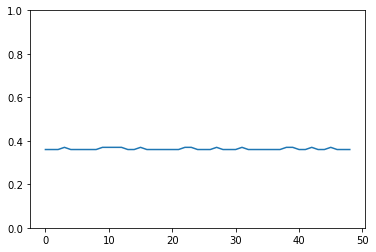

In [27]:
plt.plot(accs)
axes = plt.gca()
axes.set_ylim([0,1])

(0.0, 1.0)

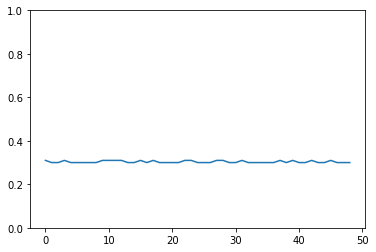

In [28]:
plt.plot(f1s)
axes = plt.gca()
axes.set_ylim([0,1])

5 документов

In [29]:
accs = []
f1s = []
for n in range(1, 50):
    prepare_augmented_train_data_for_bigartm(train_set, 'aug_train_{}.txt'.format(n), top_tokens, n, 5)
    bv_aug_train = artm.BatchVectorizer(data_path='aug_train_{}.txt'.format(n), data_format='vowpal_wabbit', 
                                        batch_size=10000, target_folder='aug_train_{}_batches'.format(n))
    new_model = artm.ARTM(num_topics=100, dictionary=dictionary, 
                      class_ids={'@default_class': 1.0, '@score': 5})
    new_model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=100))
    new_model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@score'))
    new_model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))

    new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_default', 
                                                               tau=10000, class_ids=['@default_class']))
    new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_score', 
                                                               tau=100, class_ids=['@score']))

    for i in range(10):
        new_model.fit_offline(bv_aug_train, num_collection_passes=1)
        sparsity = new_model.score_tracker['sparsity'].value[-1]
        perplexity = new_model.score_tracker['perplexity'].value[-1]
        print('Iteration {}: sparsity = {}, perplexity = {}'.format(i, sparsity, perplexity))

    X_train_pd = new_model.transform(bv_train)
    X_train = np.array([X_train_pd[i].values for i in range(len(train_scores))])
    y_train = np.array(train_scores)
    X_val_pd = new_model.transform(bv_val)
    X_val = np.array([X_val_pd[i].values for i in range(len(val_scores))])
    y_val = np.array(val_scores)

    classifier = RandomForestClassifier(n_estimators=50)
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_val_pred = classifier.predict(X_val)
    results = {}
    results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
    results['val'] = classification_report(y_val, y_val_pred, zero_division=1)
    
    print(results['val'])
    
    spl = results['val'].split()
    iddd = spl.index('accuracy') + 1
    accs.append(float(spl[iddd]))
    f1s.append(float(spl[iddd + 12]))
    print(accs, f1s)

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469814.4375
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12511.7158203125
Iteration 2: sparsity = 0.96875, perplexity = 9771.0078125
Iteration 3: sparsity = 0.96875, perplexity = 8343.287109375
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7525.9326171875
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7124.005859375
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6904.41357421875
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6780.25390625
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6705.14990234375
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6660.06640625
              precision    recall  f1-score   support

           1       0.42      0.79      0.55      1035
           2       0.17      0.07      0.10       406
           3       0.19      0.08      0.11       493
           4       0.28      0.21      0.24       561
           7       0.28      0.

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469473.40625
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12499.8095703125
Iteration 2: sparsity = 0.96875, perplexity = 9757.5439453125
Iteration 3: sparsity = 0.96875, perplexity = 8324.3388671875
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7505.64892578125
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7102.69921875
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6881.6923828125
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6755.41796875
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6677.7529296875
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6631.17578125
              precision    recall  f1-score   support

           1       0.43      0.76      0.55      1035
           2       0.15      0.06      0.08       406
           3       0.21      0.07      0.11       493
           4       0.28      0.27      0.27       561
           7       0.28     

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469133.5
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12485.97265625
Iteration 2: sparsity = 0.96875, perplexity = 9739.9140625
Iteration 3: sparsity = 0.96875, perplexity = 8302.103515625
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7485.62646484375
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7083.25830078125
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6861.31103515625
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6733.81689453125
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6655.27099609375
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6608.2294921875
              precision    recall  f1-score   support

           1       0.42      0.79      0.55      1035
           2       0.15      0.05      0.07       406
           3       0.18      0.07      0.10       493
           4       0.28      0.24      0.26       561
           7       0.26     

Iteration 8: sparsity = 0.9700000286102295, perplexity = 6637.69287109375
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6591.0400390625
              precision    recall  f1-score   support

           1       0.43      0.79      0.55      1035
           2       0.12      0.04      0.06       406
           3       0.17      0.07      0.10       493
           4       0.27      0.24      0.25       561
           7       0.27      0.15      0.19       506
           8       0.26      0.13      0.17       591
           9       0.22      0.07      0.11       431
          10       0.40      0.65      0.49       977

    accuracy                           0.36      5000
   macro avg       0.27      0.27      0.24      5000
weighted avg       0.30      0.36      0.30      5000

[0.36, 0.37, 0.36, 0.37, 0.36, 0.36, 0.37, 0.36, 0.37, 0.37, 0.36, 0.37, 0.36, 0.36, 0.37, 0.37, 0.36, 0.36] [0.3, 0.31, 0.3, 0.31, 0.3, 0.3, 0.31, 0.3, 0.31, 0.31, 0.3, 0.31, 0.3, 0.3, 0.31, 0.31, 0.3,

Iteration 0: sparsity = 0.8525000214576721, perplexity = 468513.21875
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12456.314453125
Iteration 2: sparsity = 0.96875, perplexity = 9698.3349609375
Iteration 3: sparsity = 0.96875, perplexity = 8251.0244140625
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7439.52978515625
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7041.275390625
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6819.654296875
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6691.28173828125
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6613.51953125
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6567.03955078125
              precision    recall  f1-score   support

           1       0.43      0.79      0.56      1035
           2       0.16      0.06      0.08       406
           3       0.18      0.06      0.09       493
           4       0.25      0.24      0.25       561
           7       0.29  

Iteration 0: sparsity = 0.8525000214576721, perplexity = 468232.5
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12441.267578125
Iteration 2: sparsity = 0.96875, perplexity = 9676.228515625
Iteration 3: sparsity = 0.96875, perplexity = 8224.318359375
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7415.55712890625
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7020.82373046875
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6800.3935546875
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6671.705078125
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6593.89892578125
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6548.35009765625
              precision    recall  f1-score   support

           1       0.43      0.80      0.56      1035
           2       0.13      0.05      0.07       406
           3       0.19      0.07      0.10       493
           4       0.26      0.25      0.25       561
           7       0.24    

Iteration 0: sparsity = 0.8525000214576721, perplexity = 467952.5625
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12425.369140625
Iteration 2: sparsity = 0.96875, perplexity = 9652.4365234375
Iteration 3: sparsity = 0.96875, perplexity = 8195.6865234375
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7389.42626953125
Iteration 5: sparsity = 0.9700000286102295, perplexity = 6997.2373046875
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6779.3427734375
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6652.41845703125
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6575.0888671875
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6530.025390625
              precision    recall  f1-score   support

           1       0.43      0.77      0.55      1035
           2       0.14      0.05      0.08       406
           3       0.20      0.08      0.11       493
           4       0.25      0.25      0.25       561
           7       0.29 

Iteration 0: sparsity = 0.8525000214576721, perplexity = 467673.34375
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12408.6923828125
Iteration 2: sparsity = 0.96875, perplexity = 9627.1494140625
Iteration 3: sparsity = 0.96875, perplexity = 8165.6279296875
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7361.90966796875
Iteration 5: sparsity = 0.9700000286102295, perplexity = 6970.8701171875
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6753.294921875
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6626.7734375
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6550.89013671875
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6506.34130859375
              precision    recall  f1-score   support

           1       0.43      0.79      0.56      1035
           2       0.14      0.05      0.08       406
           3       0.22      0.08      0.11       493
           4       0.25      0.24      0.25       561
           7       0.27 

Iteration 0: sparsity = 0.8525000214576721, perplexity = 467394.90625
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12391.3046875
Iteration 2: sparsity = 0.96875, perplexity = 9600.5341796875
Iteration 3: sparsity = 0.96875, perplexity = 8134.21044921875
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7333.337890625
Iteration 5: sparsity = 0.9700000286102295, perplexity = 6944.453125
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6727.54833984375
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6600.427734375
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6524.47509765625
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6480.666015625
              precision    recall  f1-score   support

           1       0.43      0.77      0.55      1035
           2       0.15      0.05      0.08       406
           3       0.22      0.09      0.13       493
           4       0.26      0.25      0.25       561
           7       0.30      0

              precision    recall  f1-score   support

           1       0.43      0.76      0.55      1035
           2       0.12      0.05      0.07       406
           3       0.23      0.08      0.12       493
           4       0.27      0.25      0.26       561
           7       0.29      0.15      0.20       506
           8       0.23      0.11      0.15       591
           9       0.25      0.10      0.15       431
          10       0.40      0.65      0.50       977

    accuracy                           0.36      5000
   macro avg       0.28      0.27      0.25      5000
weighted avg       0.31      0.36      0.31      5000

[0.36, 0.37, 0.36, 0.37, 0.36, 0.36, 0.37, 0.36, 0.37, 0.37, 0.36, 0.37, 0.36, 0.36, 0.37, 0.37, 0.36, 0.36, 0.36, 0.36, 0.36, 0.37, 0.36, 0.36, 0.37, 0.36, 0.35, 0.37, 0.36, 0.37, 0.36, 0.37, 0.37, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36] [0.3, 0.31, 0.3, 0.31, 0.3, 0.3, 0.31, 0.3, 0.31, 0.31, 0.3,

(0.0, 1.0)

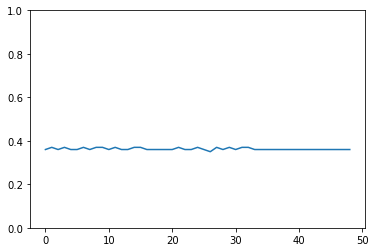

In [33]:
plt.plot(accs)
axes = plt.gca()
axes.set_ylim([0,1])

(0.0, 1.0)

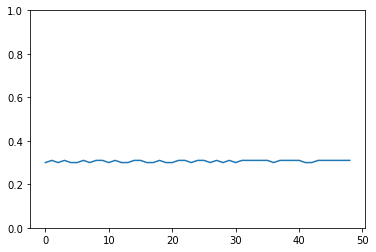

In [32]:
plt.plot(f1s)
axes = plt.gca()
axes.set_ylim([0,1])

10 документов

In [46]:
accs = []
f1s = []
for n in range(1, 50):
    prepare_augmented_train_data_for_bigartm(train_set, 'aug_train_{}.txt'.format(n), top_tokens, n, 10)
    bv_aug_train = artm.BatchVectorizer(data_path='aug_train_{}.txt'.format(n), data_format='vowpal_wabbit', 
                                        batch_size=10000, target_folder='aug_train_{}_batches'.format(n))
    new_model = artm.ARTM(num_topics=100, dictionary=dictionary, 
                      class_ids={'@default_class': 1.0, '@score': 5})
    new_model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=100))
    new_model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@score'))
    new_model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))

    new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_default', 
                                                               tau=10000, class_ids=['@default_class']))
    new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_score', 
                                                               tau=100, class_ids=['@score']))

    for i in range(20):
        new_model.fit_offline(bv_aug_train, num_collection_passes=1)
        sparsity = new_model.score_tracker['sparsity'].value[-1]
        perplexity = new_model.score_tracker['perplexity'].value[-1]
        print('Iteration {}: sparsity = {}, perplexity = {}'.format(i, sparsity, perplexity))

    X_train_pd = new_model.transform(bv_train)
    X_train = np.array([X_train_pd[i].values for i in range(len(train_scores))])
    y_train = np.array(train_scores)
    X_val_pd = new_model.transform(bv_val)
    X_val = np.array([X_val_pd[i].values for i in range(len(val_scores))])
    y_val = np.array(val_scores)

    classifier = RandomForestClassifier(n_estimators=50)
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_val_pred = classifier.predict(X_val)
    results = {}
    results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
    results['val'] = classification_report(y_val, y_val_pred, zero_division=1)
    
    print(results['val'])
    
    spl = results['val'].split()
    iddd = spl.index('accuracy') + 1
    accs.append(float(spl[iddd]))
    f1s.append(float(spl[iddd + 12]))
    print(accs, f1s)

Iteration 0: sparsity = 0.8487499952316284, perplexity = 468954.375
Iteration 1: sparsity = 0.9662500023841858, perplexity = 13230.2265625
Iteration 2: sparsity = 0.9700000286102295, perplexity = 9794.7236328125
Iteration 3: sparsity = 0.9700000286102295, perplexity = 8370.8720703125
Iteration 4: sparsity = 0.9712499976158142, perplexity = 7553.13330078125
Iteration 5: sparsity = 0.9712499976158142, perplexity = 7146.71435546875
Iteration 6: sparsity = 0.9712499976158142, perplexity = 6918.171875
Iteration 7: sparsity = 0.9712499976158142, perplexity = 6787.30126953125
Iteration 8: sparsity = 0.9712499976158142, perplexity = 6708.38330078125
Iteration 9: sparsity = 0.9712499976158142, perplexity = 6663.0302734375
Iteration 10: sparsity = 0.9712499976158142, perplexity = 6641.01318359375
Iteration 11: sparsity = 0.9712499976158142, perplexity = 6636.52490234375
Iteration 12: sparsity = 0.9712499976158142, perplexity = 6645.28955078125
Iteration 13: sparsity = 0.9712499976158142, perplex

Iteration 0: sparsity = 0.8487499952316284, perplexity = 468502.71875
Iteration 1: sparsity = 0.9662500023841858, perplexity = 13218.1162109375
Iteration 2: sparsity = 0.9700000286102295, perplexity = 9780.3193359375
Iteration 3: sparsity = 0.9700000286102295, perplexity = 8348.14453125
Iteration 4: sparsity = 0.9712499976158142, perplexity = 7529.28857421875
Iteration 5: sparsity = 0.9712499976158142, perplexity = 7123.2880859375
Iteration 6: sparsity = 0.9712499976158142, perplexity = 6894.73828125
Iteration 7: sparsity = 0.9712499976158142, perplexity = 6763.8642578125
Iteration 8: sparsity = 0.9712499976158142, perplexity = 6684.3232421875
Iteration 9: sparsity = 0.9712499976158142, perplexity = 6637.9521484375
Iteration 10: sparsity = 0.9712499976158142, perplexity = 6615.5556640625
Iteration 11: sparsity = 0.9712499976158142, perplexity = 6611.83642578125
Iteration 12: sparsity = 0.9712499976158142, perplexity = 6622.1240234375
Iteration 13: sparsity = 0.9712499976158142, perplex

Iteration 0: sparsity = 0.8487499952316284, perplexity = 468053.0
Iteration 1: sparsity = 0.9662500023841858, perplexity = 13203.64453125
Iteration 2: sparsity = 0.9700000286102295, perplexity = 9760.931640625
Iteration 3: sparsity = 0.9700000286102295, perplexity = 8321.078125
Iteration 4: sparsity = 0.9712499976158142, perplexity = 7504.13427734375
Iteration 5: sparsity = 0.9712499976158142, perplexity = 7100.6181640625
Iteration 6: sparsity = 0.9712499976158142, perplexity = 6872.806640625
Iteration 7: sparsity = 0.9712499976158142, perplexity = 6741.1865234375
Iteration 8: sparsity = 0.9712499976158142, perplexity = 6660.552734375
Iteration 9: sparsity = 0.9712499976158142, perplexity = 6613.55712890625
Iteration 10: sparsity = 0.9712499976158142, perplexity = 6590.81982421875
Iteration 11: sparsity = 0.9712499976158142, perplexity = 6586.138671875
Iteration 12: sparsity = 0.9712499976158142, perplexity = 6595.0947265625
Iteration 13: sparsity = 0.9712499976158142, perplexity = 661

Iteration 0: sparsity = 0.8487499952316284, perplexity = 467605.25
Iteration 1: sparsity = 0.9662500023841858, perplexity = 13187.0302734375
Iteration 2: sparsity = 0.9700000286102295, perplexity = 9737.166015625
Iteration 3: sparsity = 0.9700000286102295, perplexity = 8289.740234375
Iteration 4: sparsity = 0.9712499976158142, perplexity = 7475.609375
Iteration 5: sparsity = 0.9712499976158142, perplexity = 7073.775390625
Iteration 6: sparsity = 0.9712499976158142, perplexity = 6846.37109375
Iteration 7: sparsity = 0.9712499976158142, perplexity = 6715.40625
Iteration 8: sparsity = 0.9712499976158142, perplexity = 6635.4736328125
Iteration 9: sparsity = 0.9712499976158142, perplexity = 6590.0849609375
Iteration 10: sparsity = 0.9712499976158142, perplexity = 6568.5302734375
Iteration 11: sparsity = 0.9712499976158142, perplexity = 6564.72802734375
Iteration 12: sparsity = 0.9712499976158142, perplexity = 6574.5126953125
Iteration 13: sparsity = 0.9712499976158142, perplexity = 6594.490

Iteration 19: sparsity = 0.9725000262260437, perplexity = 6788.41259765625
              precision    recall  f1-score   support

           1       0.42      0.75      0.54       979
           2       0.18      0.08      0.11       458
           3       0.17      0.09      0.11       497
           4       0.25      0.25      0.25       537
           7       0.34      0.22      0.26       533
           8       0.21      0.13      0.16       560
           9       0.24      0.14      0.18       465
          10       0.44      0.60      0.50       971

    accuracy                           0.36      5000
   macro avg       0.28      0.28      0.27      5000
weighted avg       0.31      0.36      0.31      5000

[0.36, 0.35, 0.35, 0.36, 0.35, 0.36, 0.36, 0.36, 0.36, 0.35, 0.36, 0.36, 0.35, 0.35, 0.35, 0.36] [0.32, 0.31, 0.31, 0.32, 0.31, 0.32, 0.32, 0.32, 0.32, 0.31, 0.31, 0.32, 0.31, 0.31, 0.31, 0.31]
Iteration 0: sparsity = 0.8487499952316284, perplexity = 467159.40625
Iteration 

Iteration 4: sparsity = 0.9712499976158142, perplexity = 7413.3369140625
Iteration 5: sparsity = 0.9712499976158142, perplexity = 7016.18115234375
Iteration 6: sparsity = 0.9712499976158142, perplexity = 6790.87255859375
Iteration 7: sparsity = 0.9712499976158142, perplexity = 6662.9765625
Iteration 8: sparsity = 0.9712499976158142, perplexity = 6586.513671875
Iteration 9: sparsity = 0.9712499976158142, perplexity = 6543.3369140625
Iteration 10: sparsity = 0.9712499976158142, perplexity = 6523.326171875
Iteration 11: sparsity = 0.9712499976158142, perplexity = 6521.0859375
Iteration 12: sparsity = 0.9712499976158142, perplexity = 6533.134765625
Iteration 13: sparsity = 0.9712499976158142, perplexity = 6555.884765625
Iteration 14: sparsity = 0.9712499976158142, perplexity = 6586.240234375
Iteration 15: sparsity = 0.9725000262260437, perplexity = 6621.75244140625
Iteration 16: sparsity = 0.9725000262260437, perplexity = 6660.0703125
Iteration 17: sparsity = 0.9725000262260437, perplexity

Iteration 19: sparsity = 0.9725000262260437, perplexity = 6744.75439453125
              precision    recall  f1-score   support

           1       0.41      0.75      0.53       979
           2       0.18      0.08      0.11       458
           3       0.15      0.07      0.10       497
           4       0.24      0.24      0.24       537
           7       0.31      0.19      0.24       533
           8       0.21      0.12      0.16       560
           9       0.23      0.11      0.15       465
          10       0.43      0.59      0.50       971

    accuracy                           0.35      5000
   macro avg       0.27      0.27      0.25      5000
weighted avg       0.30      0.35      0.30      5000

[0.36, 0.35, 0.35, 0.36, 0.35, 0.36, 0.36, 0.36, 0.36, 0.35, 0.36, 0.36, 0.35, 0.35, 0.35, 0.36, 0.36, 0.36, 0.35, 0.35, 0.35, 0.36, 0.35] [0.32, 0.31, 0.31, 0.32, 0.31, 0.32, 0.32, 0.32, 0.32, 0.31, 0.31, 0.32, 0.31, 0.31, 0.31, 0.31, 0.32, 0.32, 0.31, 0.31, 0.31, 0.32, 0.

Iteration 0: sparsity = 0.8487499952316284, perplexity = 466053.25
Iteration 1: sparsity = 0.9662500023841858, perplexity = 13115.2890625
Iteration 2: sparsity = 0.9700000286102295, perplexity = 9627.0390625
Iteration 3: sparsity = 0.9700000286102295, perplexity = 8149.4677734375
Iteration 4: sparsity = 0.9712499976158142, perplexity = 7344.09521484375
Iteration 5: sparsity = 0.9712499976158142, perplexity = 6953.6572265625
Iteration 6: sparsity = 0.9712499976158142, perplexity = 6732.55029296875
Iteration 7: sparsity = 0.9712499976158142, perplexity = 6607.85205078125
Iteration 8: sparsity = 0.9712499976158142, perplexity = 6534.5966796875
Iteration 9: sparsity = 0.9712499976158142, perplexity = 6493.6767578125
Iteration 10: sparsity = 0.9712499976158142, perplexity = 6475.3759765625
Iteration 11: sparsity = 0.9712499976158142, perplexity = 6475.052734375
Iteration 12: sparsity = 0.9712499976158142, perplexity = 6487.470703125
Iteration 13: sparsity = 0.9712499976158142, perplexity = 

Iteration 12: sparsity = 0.9712499976158142, perplexity = 6466.95947265625
Iteration 13: sparsity = 0.9712499976158142, perplexity = 6488.7314453125
Iteration 14: sparsity = 0.9712499976158142, perplexity = 6515.443359375
Iteration 15: sparsity = 0.9712499976158142, perplexity = 6546.3662109375
Iteration 16: sparsity = 0.9725000262260437, perplexity = 6580.0703125
Iteration 17: sparsity = 0.9725000262260437, perplexity = 6615.38134765625
Iteration 18: sparsity = 0.9725000262260437, perplexity = 6651.767578125
Iteration 19: sparsity = 0.9725000262260437, perplexity = 6687.84130859375
              precision    recall  f1-score   support

           1       0.42      0.74      0.53       979
           2       0.22      0.09      0.13       458
           3       0.16      0.09      0.12       497
           4       0.23      0.23      0.23       537
           7       0.31      0.20      0.24       533
           8       0.27      0.17      0.20       560
           9       0.26      0.

Iteration 0: sparsity = 0.8487499952316284, perplexity = 465286.0
Iteration 1: sparsity = 0.9662500023841858, perplexity = 13073.1279296875
Iteration 2: sparsity = 0.9700000286102295, perplexity = 9559.8544921875
Iteration 3: sparsity = 0.9700000286102295, perplexity = 8067.5947265625
Iteration 4: sparsity = 0.9712499976158142, perplexity = 7270.03857421875
Iteration 5: sparsity = 0.9712499976158142, perplexity = 6888.65283203125
Iteration 6: sparsity = 0.9712499976158142, perplexity = 6676.53662109375
Iteration 7: sparsity = 0.9712499976158142, perplexity = 6556.53369140625
Iteration 8: sparsity = 0.9712499976158142, perplexity = 6484.29736328125
Iteration 9: sparsity = 0.9712499976158142, perplexity = 6444.146484375
Iteration 10: sparsity = 0.9712499976158142, perplexity = 6426.13525390625
Iteration 11: sparsity = 0.9712499976158142, perplexity = 6424.14404296875
Iteration 12: sparsity = 0.9712499976158142, perplexity = 6434.73291015625
Iteration 13: sparsity = 0.9712499976158142, pe

Iteration 9: sparsity = 0.9712499976158142, perplexity = 6422.8720703125
Iteration 10: sparsity = 0.9712499976158142, perplexity = 6404.26318359375
Iteration 11: sparsity = 0.9712499976158142, perplexity = 6402.31005859375
Iteration 12: sparsity = 0.9712499976158142, perplexity = 6412.98046875
Iteration 13: sparsity = 0.9712499976158142, perplexity = 6431.97021484375
Iteration 14: sparsity = 0.9712499976158142, perplexity = 6457.12353515625
Iteration 15: sparsity = 0.9712499976158142, perplexity = 6486.880859375
Iteration 16: sparsity = 0.9725000262260437, perplexity = 6518.54150390625
Iteration 17: sparsity = 0.9725000262260437, perplexity = 6550.68212890625
Iteration 18: sparsity = 0.9725000262260437, perplexity = 6582.78857421875
Iteration 19: sparsity = 0.9725000262260437, perplexity = 6614.10595703125
              precision    recall  f1-score   support

           1       0.42      0.77      0.54       979
           2       0.20      0.07      0.11       458
           3       

Iteration 16: sparsity = 0.9725000262260437, perplexity = 6513.927734375
Iteration 17: sparsity = 0.9725000262260437, perplexity = 6547.8701171875
Iteration 18: sparsity = 0.9725000262260437, perplexity = 6581.3251953125
Iteration 19: sparsity = 0.9725000262260437, perplexity = 6613.24951171875
              precision    recall  f1-score   support

           1       0.41      0.75      0.53       979
           2       0.22      0.08      0.11       458
           3       0.16      0.09      0.11       497
           4       0.21      0.22      0.22       537
           7       0.34      0.19      0.25       533
           8       0.24      0.16      0.19       560
           9       0.25      0.14      0.18       465
          10       0.43      0.57      0.49       971

    accuracy                           0.35      5000
   macro avg       0.28      0.27      0.26      5000
weighted avg       0.31      0.35      0.31      5000

[0.36, 0.35, 0.35, 0.36, 0.35, 0.36, 0.36, 0.36, 0.36

Iteration 0: sparsity = 0.8487499952316284, perplexity = 464199.875
Iteration 1: sparsity = 0.9662500023841858, perplexity = 13007.2529296875
Iteration 2: sparsity = 0.9700000286102295, perplexity = 9454.1484375
Iteration 3: sparsity = 0.9700000286102295, perplexity = 7943.59228515625
Iteration 4: sparsity = 0.9712499976158142, perplexity = 7160.806640625
Iteration 5: sparsity = 0.9712499976158142, perplexity = 6793.69287109375
Iteration 6: sparsity = 0.9712499976158142, perplexity = 6594.4296875
Iteration 7: sparsity = 0.9712499976158142, perplexity = 6485.302734375
Iteration 8: sparsity = 0.9712499976158142, perplexity = 6421.59814453125
Iteration 9: sparsity = 0.9712499976158142, perplexity = 6387.46435546875
Iteration 10: sparsity = 0.9712499976158142, perplexity = 6374.966796875
Iteration 11: sparsity = 0.9712499976158142, perplexity = 6379.76123046875
Iteration 12: sparsity = 0.9712499976158142, perplexity = 6397.6982421875
Iteration 13: sparsity = 0.9712499976158142, perplexity 

Iteration 4: sparsity = 0.9712499976158142, perplexity = 7127.3916015625
Iteration 5: sparsity = 0.9712499976158142, perplexity = 6765.09326171875
Iteration 6: sparsity = 0.9712499976158142, perplexity = 6569.67724609375
Iteration 7: sparsity = 0.9712499976158142, perplexity = 6463.8369140625
Iteration 8: sparsity = 0.9712499976158142, perplexity = 6403.974609375
Iteration 9: sparsity = 0.9712499976158142, perplexity = 6374.16357421875
Iteration 10: sparsity = 0.9712499976158142, perplexity = 6364.84765625
Iteration 11: sparsity = 0.9712499976158142, perplexity = 6371.97900390625
Iteration 12: sparsity = 0.9712499976158142, perplexity = 6392.345703125
Iteration 13: sparsity = 0.9712499976158142, perplexity = 6420.74462890625
Iteration 14: sparsity = 0.9712499976158142, perplexity = 6453.47412109375
Iteration 15: sparsity = 0.9712499976158142, perplexity = 6487.53662109375
Iteration 16: sparsity = 0.9725000262260437, perplexity = 6521.525390625
Iteration 17: sparsity = 0.972500026226043

(0.0, 1.0)

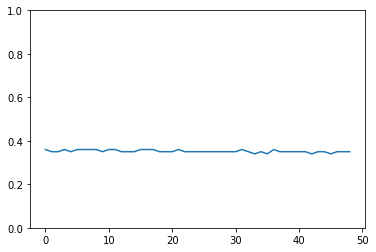

In [47]:
plt.plot(accs)
axes = plt.gca()
axes.set_ylim([0,1])

(0.0, 1.0)

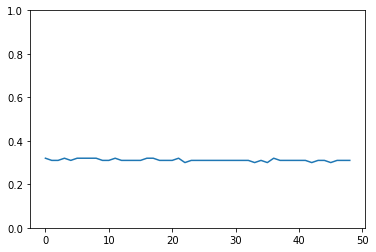

In [48]:
plt.plot(f1s)
axes = plt.gca()
axes.set_ylim([0,1])

Зафиксируем 50 слов в документе и посмотрим на зависимость от количества документов.

In [34]:
accs = []
f1s = []
for n in range(1, 50):
    prepare_augmented_train_data_for_bigartm(train_set, 'aug_train_{}.txt'.format(n), top_tokens, 50, n)
    bv_aug_train = artm.BatchVectorizer(data_path='aug_train_{}.txt'.format(n), data_format='vowpal_wabbit', 
                                        batch_size=10000, target_folder='aug_train_{}_batches'.format(n))
    new_model = artm.ARTM(num_topics=100, dictionary=dictionary, 
                      class_ids={'@default_class': 1.0, '@score': 5})
    new_model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=100))
    new_model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@score'))
    new_model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))

    new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_default', 
                                                               tau=10000, class_ids=['@default_class']))
    new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_score', 
                                                               tau=100, class_ids=['@score']))

    for i in range(10):
        new_model.fit_offline(bv_aug_train, num_collection_passes=1)
        sparsity = new_model.score_tracker['sparsity'].value[-1]
        perplexity = new_model.score_tracker['perplexity'].value[-1]
        print('Iteration {}: sparsity = {}, perplexity = {}'.format(i, sparsity, perplexity))

    X_train_pd = new_model.transform(bv_train)
    X_train = np.array([X_train_pd[i].values for i in range(len(train_scores))])
    y_train = np.array(train_scores)
    X_val_pd = new_model.transform(bv_val)
    X_val = np.array([X_val_pd[i].values for i in range(len(val_scores))])
    y_val = np.array(val_scores)

    classifier = RandomForestClassifier(n_estimators=50)
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_val_pred = classifier.predict(X_val)
    results = {}
    results['train'] = classification_report(y_train, y_train_pred, zero_division=1)
    results['val'] = classification_report(y_val, y_val_pred, zero_division=1)
    
    print(results['val'])
    
    spl = results['val'].split()
    iddd = spl.index('accuracy') + 1
    accs.append(float(spl[iddd]))
    f1s.append(float(spl[iddd + 12]))
    print(accs, f1s)

Iteration 0: sparsity = 0.8525000214576721, perplexity = 469305.4375
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12474.373046875
Iteration 2: sparsity = 0.96875, perplexity = 9731.689453125
Iteration 3: sparsity = 0.96875, perplexity = 8297.6328125
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7482.9150390625
Iteration 5: sparsity = 0.9700000286102295, perplexity = 7080.81298828125
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6860.64794921875
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6735.201171875
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6658.17529296875
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6611.7451171875
              precision    recall  f1-score   support

           1       0.43      0.79      0.56      1035
           2       0.16      0.05      0.08       406
           3       0.23      0.07      0.11       493
           4       0.26      0.25      0.26       561
           7       0.28    

Iteration 0: sparsity = 0.8525000214576721, perplexity = 465959.34375
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12323.56640625
Iteration 2: sparsity = 0.96875, perplexity = 9486.8994140625
Iteration 3: sparsity = 0.96875, perplexity = 7996.2255859375
Iteration 4: sparsity = 0.9700000286102295, perplexity = 7205.25244140625
Iteration 5: sparsity = 0.9700000286102295, perplexity = 6829.931640625
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6625.20751953125
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6506.27685546875
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6433.908203125
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6392.703125
              precision    recall  f1-score   support

           1       0.43      0.76      0.55      1035
           2       0.15      0.05      0.08       406
           3       0.21      0.08      0.11       493
           4       0.26      0.27      0.27       561
           7       0.27     

Iteration 0: sparsity = 0.8525000214576721, perplexity = 462737.40625
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12183.6884765625
Iteration 2: sparsity = 0.96875, perplexity = 9239.3505859375
Iteration 3: sparsity = 0.96875, perplexity = 7714.11962890625
Iteration 4: sparsity = 0.9700000286102295, perplexity = 6956.69970703125
Iteration 5: sparsity = 0.9700000286102295, perplexity = 6617.0771484375
Iteration 6: sparsity = 0.9700000286102295, perplexity = 6441.6484375
Iteration 7: sparsity = 0.9700000286102295, perplexity = 6348.806640625
Iteration 8: sparsity = 0.9700000286102295, perplexity = 6298.36572265625
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6272.82421875
              precision    recall  f1-score   support

           1       0.41      0.74      0.53      1035
           2       0.12      0.05      0.07       406
           3       0.24      0.10      0.14       493
           4       0.27      0.25      0.26       561
           7       0.25   

Iteration 0: sparsity = 0.8525000214576721, perplexity = 459605.4375
Iteration 1: sparsity = 0.9649999737739563, perplexity = 12050.2529296875
Iteration 2: sparsity = 0.96875, perplexity = 9003.9658203125
Iteration 3: sparsity = 0.96875, perplexity = 7473.63232421875
Iteration 4: sparsity = 0.96875, perplexity = 6750.0703125
Iteration 5: sparsity = 0.96875, perplexity = 6431.0673828125
Iteration 6: sparsity = 0.96875, perplexity = 6273.0771484375
Iteration 7: sparsity = 0.96875, perplexity = 6195.50390625
Iteration 8: sparsity = 0.96875, perplexity = 6159.90771484375
Iteration 9: sparsity = 0.9700000286102295, perplexity = 6150.546875
              precision    recall  f1-score   support

           1       0.44      0.76      0.55      1035
           2       0.17      0.06      0.09       406
           3       0.22      0.09      0.13       493
           4       0.23      0.22      0.22       561
           7       0.25      0.16      0.20       506
           8       0.29      0.1

Iteration 8: sparsity = 0.96875, perplexity = 6038.35986328125
Iteration 9: sparsity = 0.96875, perplexity = 6027.64599609375
              precision    recall  f1-score   support

           1       0.43      0.74      0.54      1035
           2       0.14      0.05      0.07       406
           3       0.23      0.12      0.16       493
           4       0.24      0.24      0.24       561
           7       0.23      0.15      0.18       506
           8       0.26      0.16      0.20       591
           9       0.20      0.08      0.12       431
          10       0.41      0.59      0.48       977

    accuracy                           0.35      5000
   macro avg       0.27      0.27      0.25      5000
weighted avg       0.30      0.35      0.31      5000

[0.37, 0.37, 0.37, 0.36, 0.35, 0.36, 0.36, 0.36, 0.35, 0.36, 0.36, 0.35, 0.35, 0.35, 0.36, 0.35, 0.35, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.35] [0.31, 0.31, 0.31, 0.31, 0.3, 0.31, 0.31, 0.3, 0.3, 0.3, 0.31, 0.3, 0.3, 0.3, 

Iteration 0: sparsity = 0.8525000214576721, perplexity = 454114.125
Iteration 1: sparsity = 0.9649999737739563, perplexity = 11766.0205078125
Iteration 2: sparsity = 0.96875, perplexity = 8561.689453125
Iteration 3: sparsity = 0.96875, perplexity = 7039.689453125
Iteration 4: sparsity = 0.96875, perplexity = 6373.39501953125
Iteration 5: sparsity = 0.96875, perplexity = 6095.3291015625
Iteration 6: sparsity = 0.96875, perplexity = 5963.7568359375
Iteration 7: sparsity = 0.96875, perplexity = 5899.953125
Iteration 8: sparsity = 0.96875, perplexity = 5867.24658203125
Iteration 9: sparsity = 0.96875, perplexity = 5851.35009765625
              precision    recall  f1-score   support

           1       0.43      0.73      0.54      1035
           2       0.16      0.08      0.10       406
           3       0.25      0.13      0.17       493
           4       0.26      0.20      0.23       561
           7       0.27      0.16      0.20       506
           8       0.23      0.16      0

Iteration 0: sparsity = 0.8525000214576721, perplexity = 451725.375
Iteration 1: sparsity = 0.9649999737739563, perplexity = 11641.4482421875
Iteration 2: sparsity = 0.96875, perplexity = 8361.77734375
Iteration 3: sparsity = 0.96875, perplexity = 6838.06884765625
Iteration 4: sparsity = 0.96875, perplexity = 6188.80078125
Iteration 5: sparsity = 0.96875, perplexity = 5923.47900390625
Iteration 6: sparsity = 0.96875, perplexity = 5799.525390625
Iteration 7: sparsity = 0.96875, perplexity = 5739.48046875
Iteration 8: sparsity = 0.96875, perplexity = 5708.4677734375
Iteration 9: sparsity = 0.96875, perplexity = 5692.89599609375
              precision    recall  f1-score   support

           1       0.41      0.72      0.52      1035
           2       0.16      0.07      0.10       406
           3       0.26      0.12      0.17       493
           4       0.25      0.17      0.20       561
           7       0.22      0.15      0.18       506
           8       0.26      0.18      0.

Iteration 0: sparsity = 0.8525000214576721, perplexity = 449378.46875
Iteration 1: sparsity = 0.9649999737739563, perplexity = 11494.4208984375
Iteration 2: sparsity = 0.96875, perplexity = 8167.6708984375
Iteration 3: sparsity = 0.96875, perplexity = 6654.71142578125
Iteration 4: sparsity = 0.96875, perplexity = 6024.40478515625
Iteration 5: sparsity = 0.96875, perplexity = 5767.43505859375
Iteration 6: sparsity = 0.96875, perplexity = 5646.42822265625
Iteration 7: sparsity = 0.96875, perplexity = 5588.04052734375
Iteration 8: sparsity = 0.96875, perplexity = 5557.521484375
Iteration 9: sparsity = 0.96875, perplexity = 5542.0888671875
              precision    recall  f1-score   support

           1       0.43      0.72      0.54      1035
           2       0.19      0.09      0.12       406
           3       0.25      0.12      0.16       493
           4       0.24      0.19      0.21       561
           7       0.23      0.16      0.19       506
           8       0.25      0.

Iteration 0: sparsity = 0.8525000214576721, perplexity = 447096.28125
Iteration 1: sparsity = 0.9649999737739563, perplexity = 11357.0751953125
Iteration 2: sparsity = 0.96875, perplexity = 7971.79345703125
Iteration 3: sparsity = 0.96875, perplexity = 6464.669921875
Iteration 4: sparsity = 0.96875, perplexity = 5848.89990234375
Iteration 5: sparsity = 0.96875, perplexity = 5594.86279296875
Iteration 6: sparsity = 0.96875, perplexity = 5471.2890625
Iteration 7: sparsity = 0.96875, perplexity = 5407.08203125
Iteration 8: sparsity = 0.96875, perplexity = 5370.72705078125
Iteration 9: sparsity = 0.96875, perplexity = 5351.54443359375
              precision    recall  f1-score   support

           1       0.42      0.74      0.54      1035
           2       0.19      0.09      0.12       406
           3       0.24      0.11      0.15       493
           4       0.29      0.22      0.25       561
           7       0.22      0.16      0.19       506
           8       0.25      0.17   

(0.0, 1.0)

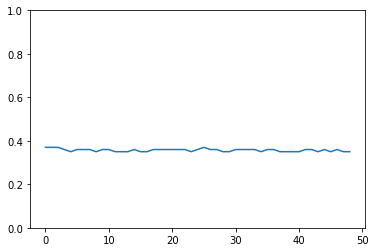

In [35]:
plt.plot(accs)
axes = plt.gca()
axes.set_ylim([0,1])

(0.0, 1.0)

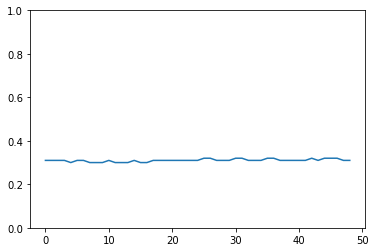

In [36]:
plt.plot(f1s)
axes = plt.gca()
axes.set_ylim([0,1])

(0.0, 1.0)

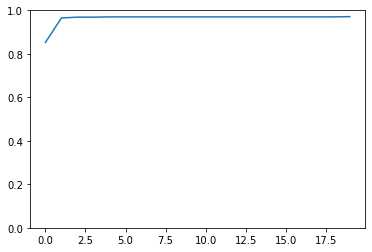

In [52]:
plt.plot(model.score_tracker['sparsity'].value)
axes = plt.gca()
axes.set_ylim([0,1])

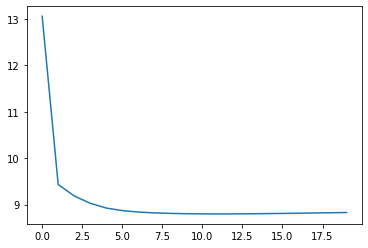

In [53]:
plt.plot(np.log(model.score_tracker['perplexity'].value))